In [ ]:
!pip install -q -U git+https://github.com/AI4EPS/GaMMA.git
!pip install -q -U git+https://github.com/AI4EPS/ADLoc.git
!cp QuakeFlow/scripts/run_hypodd_ct.sh ./

In [1]:
# %%
import json
import os
import sys
from datetime import datetime
from typing import Dict, List, NamedTuple

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import obspy
import obspy.clients.fdsn
import pandas as pd
from obspy.clients.fdsn.mass_downloader import (
    CircularDomain,
    MassDownloader,
    Restrictions,
)
from pyproj import Proj
from adloc.eikonal2d import init_eikonal2d
from adloc.sacloc2d import ADLoc
from adloc.utils import invert_location
from gamma.utils import association, estimate_eps
from tqdm import tqdm


In [3]:
region = "demo"

In [4]:
def set_config(root_path: str = "local", region: str = "demo") -> Dict:

    if not os.path.exists(f"{root_path}/{region}"):
        os.makedirs(f"{root_path}/{region}", exist_ok=True)

    regions = {
            "demo": {
                "longitude0": -117.504,
                "latitude0": 35.705,
                "maxradius_degree": 0.5,
                "mindepth": 0,
                "maxdepth": 20,
                "starttime": "2019-07-04T00:00:00",
                "endtime": "2019-07-05T00:00:00",
                "network": "CI",
                "channel": "HH*,BH*,EH*,HN*",
                "provider": [
                    "SCEDC"
                ],
            },
            "ridgecrest": {
                "longitude0": -117.504,
                "latitude0": 35.705,
                "maxradius_degree": 1.0,
                "mindepth": 0,
                "maxdepth": 20,
                "starttime": "2019-07-04T00:00:00",
                "endtime": "2019-07-10T00:00:00",
                "network": "CI",
                "channel": "HH*,BH*,EH*,HN*",
                "provider": [
                    "SCEDC"
                ],
            },
    }

    ## Set config
    config = regions[region.lower()]

    ## PhaseNet
    config["phasenet"] = {}
    ## GaMMA
    config["gamma"] = {}
    ## ADLoc
    config["adloc"] = {}
    ## HypoDD
    config["hypodd"] = {}

    with open(f"{root_path}/{region}/config.json", "w") as fp:
        json.dump(config, fp, indent=2)

    print(json.dumps(config, indent=4))

    return config

In [5]:
config  = set_config(region = region)

{
    "longitude0": -117.504,
    "latitude0": 35.705,
    "maxradius_degree": 0.5,
    "mindepth": 0,
    "maxdepth": 20,
    "starttime": "2019-07-04T00:00:00",
    "endtime": "2019-07-05T00:00:00",
    "network": "CI",
    "channel": "HH*,BH*,EH*,HN*",
    "provider": [
        "SCEDC"
    ],
    "phasenet": {},
    "gamma": {},
    "adloc": {},
    "hypodd": {}
}


In [6]:
def plot_catalog(catalog: pd.DataFrame, method="Standard", region: str = "demo", config: Dict = {}):
    ## Plot earthquake locations
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2)

    scatter = ax.scatter(
        catalog['longitude'],
        catalog['latitude'],
        c=catalog['depth_km'],
        cmap='viridis_r',
        s=1,
        alpha=0.6,
        vmin = config["mindepth"],
        vmax = config["maxdepth"],
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(scatter, label='Depth (km)')
    ax.set_extent([config["longitude0"] - config["maxradius_degree"]/2, config["longitude0"] + config["maxradius_degree"]/2, config["latitude0"] - config["maxradius_degree"]/2, config["latitude0"] + config["maxradius_degree"]/2])

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.title(f'{method} Catalog ({len(catalog)})')
    plt.show()

def plot_stations(stations: pd.DataFrame, catalog: pd.DataFrame=None, region: str = "demo", config: Dict = {}):
    ## Plot earthquake locations
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2)

    scatter = ax.scatter(
        stations['longitude'],
        stations['latitude'],
        c="C0",
        s=40,
        marker="^",
        alpha=0.6,
        transform=ccrs.PlateCarree()
    )
    if catalog is not None:
        scatter = ax.scatter(
            catalog['longitude'],
            catalog['latitude'],
            c=catalog['depth_km'],
            cmap='viridis_r',
            s=1,
            alpha=0.6,
            vmin = config["mindepth"],
            vmax = config["maxdepth"],
            transform=ccrs.PlateCarree()
        )
        plt.colorbar(scatter, label='Depth (km)')
    ax.set_extent([config["longitude0"] - config["maxradius_degree"], config["longitude0"] + config["maxradius_degree"], config["latitude0"] - config["maxradius_degree"], config["latitude0"] + config["maxradius_degree"]])

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.title(f'Stations ({len(stations["station"].unique())})')
    plt.show()

def download_catalog(root_path: str = "local", region: str = "demo", config: Dict = {}):

    result_path = f"{region}/obspy"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")
    # print(json.dumps(config, indent=4))

    ## Download catalog 
    client = obspy.clients.fdsn.Client("usgs")
    events = client.get_events(
        starttime=config["starttime"],
        endtime=config["endtime"],
        latitude=config["latitude0"],
        longitude=config["longitude0"],
        maxradius=config["maxradius_degree"],
    )
    print(f"Number of events: {len(events)}")

    ## Save catalog
    catalog = defaultdict(list)
    for event in events:
        if len(event.magnitudes) > 0:
            catalog["time"].append(event.origins[0].time.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f"))
            catalog["magnitude"].append(event.magnitudes[0].mag)
            catalog["longitude"].append(event.origins[0].longitude)
            catalog["latitude"].append(event.origins[0].latitude)
            catalog["depth_km"].append(event.origins[0].depth/1e3)
    catalog = pd.DataFrame.from_dict(catalog).sort_values(["time"])
    catalog.to_csv(f"{root_path}/{result_path}/catalog.csv", index=False)

    return catalog

Number of events: 709


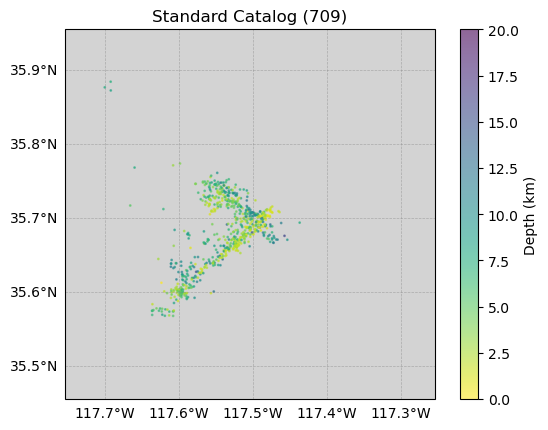

In [7]:
standard_catalog = download_catalog(region=region, config=config)
plot_catalog(standard_catalog, method="Standard", config=config)

In [8]:
def download_station(root_path: str = "local", region: str = "demo", config: Dict = {}):

    result_dir = f"{region}/obspy"
    if not os.path.exists(f"{root_path}/{result_dir}"):
        os.makedirs(f"{root_path}/{result_dir}")
    if not os.path.exists(f"{root_path}/{result_dir}/inventory/"):
        os.makedirs(f"{root_path}/{result_dir}/inventory/")

    ## Download stations
    stations = obspy.core.inventory.Inventory()
    for provider in config["provider"]:
        client = obspy.clients.fdsn.Client(provider)
        stations += client.get_stations(
                network=config["network"],
                station="*",
                starttime=config["starttime"],
                endtime=config["endtime"],
                latitude=config["latitude0"],
                longitude=config["longitude0"],
                maxradius=config["maxradius_degree"],
                channel=config["channel"],
                level="response",
            )
    stations.write(f"{root_path}/{result_dir}/inventory.xml", format="STATIONXML")
    print("Number of stations: {}".format(sum([len(x) for x in stations])))

    ## Save stations
    station_dict = defaultdict(dict)
    for network in stations:
        for station in network:
            inv = stations.select(network=network.code, station=station.code)
            inv.write(f"{root_path}/{result_dir}/inventory/{network.code}.{station.code}.xml", format="STATIONXML")
            for channel in station:
                sid = f"{network.code}.{station.code}.{channel.location_code}.{channel.code}"
                station_dict[sid] = {
                    "network": network.code,
                    "station": station.code,
                    "location": channel.location_code,
                    "channel": channel.code,
                    "longitude": channel.longitude,
                    "latitude": channel.latitude,
                    "elevation_m": channel.elevation,
                    "response": round(channel.response.instrument_sensitivity.value, 2),
                }

    with open(f"{root_path}/{result_dir}/stations.json", "w") as fp:
        json.dump(station_dict, fp, indent=2)

    with open(f"{root_path}/{result_dir}/stations.pkl", "wb") as fp:
        pickle.dump(stations, fp)
    
    return pd.DataFrame.from_dict(station_dict, orient="index")

Number of stations: 15


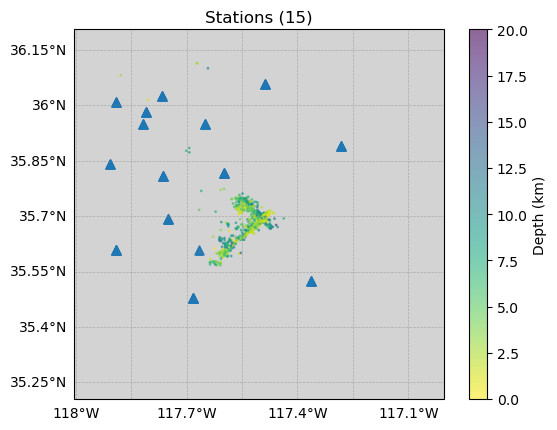

In [9]:
stations = download_station(region=region, config=config)
plot_stations(stations, catalog = standard_catalog, region=region, config=config)

In [10]:
def map_remote_path(provider, bucket, starttime, network, station, location, channel):

    starttime = pd.Timestamp(starttime).round("h").to_pydatetime()  # in case of 2021-01-01T23:59:xxx
    if provider.lower() == "scedc":
        year = starttime.strftime("%Y")
        dayofyear = starttime.strftime("%j")
        if location == "":
            location = "__"
        path = f"s3://{bucket}/{year}/{year}_{dayofyear}/{network}{station:_<5}{channel}{location:_<2}_{year}{dayofyear}.ms"
    elif provider.lower() == "ncedc":
        year = starttime.strftime("%Y")
        dayofyear = starttime.strftime("%j")
        path = f"s3://{bucket}/{network}/{year}/{year}.{dayofyear}/{station}.{network}.{channel}.{location}.D.{year}.{dayofyear}"
    else:
        raise ValueError(f"Unknown provider: {provider}")
    return path

def download_waveform(root_path: str = "local", region: str = "demo", config: Dict = {}):

    waveform_dir = f"{region}/waveforms"
    if not os.path.exists(f"{root_path}/{waveform_dir}"):
        os.makedirs(f"{root_path}/{waveform_dir}")
    # print(json.dumps(config, indent=4))

    ## Download from cloud
    for provider in config["provider"]:
        if provider.lower() in ["scedc", "ncedc"]:
            cloud = {
                "provider": provider.lower(),
                "bucket": f"{provider.lower()}-pds/continuous_waveforms",
            }

        DELTATIME = "1D"
        starttime = datetime.fromisoformat(config["starttime"]).strftime("%Y-%m-%d")
        starttimes = pd.date_range(starttime, config["endtime"], freq=DELTATIME, tz="UTC", inclusive="left").to_list()
        with open(f'{root_path}/{region}/obspy/stations.json', 'r') as f:
            stations = json.load(f)

        for starttime in starttimes:
            for _, station in stations.items():
                network, station, location, channel = station["network"], station["station"], station["location"], station["channel"]
                mseed_path = map_remote_path(
                    cloud["provider"],
                    cloud["bucket"],
                    starttime,
                    network,
                    station,
                    location,
                    channel,
                )
                try:
                    if os.path.exists(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed"):
                        # print(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed downloaded.")
                        continue
                    if not os.path.exists(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}"):
                        os.makedirs(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}")
                        with fsspec.open(f"{mseed_path}", "rb", s3={"anon": True}) as f:
                            data = f.read()
                        with open(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed", "wb") as f:
                            f.write(data)
                except Exception as e:
                    print(f"Failed to download {e}")

    # %% Download from FDSN
    domain = CircularDomain(
        longitude=config["longitude0"],
        latitude=config["latitude0"],
        minradius=0,
        maxradius=config["maxradius_degree"],
    )

    restrictions = Restrictions(
        starttime=obspy.UTCDateTime(config["starttime"]),
        endtime=obspy.UTCDateTime(config["endtime"]),
        chunklength_in_sec=3600 * 24, # 1 day
        network=config["network"] if "network" in config else None,
        station=config["station"] if "station" in config else None,
        minimum_interstation_distance_in_m=0,
        minimum_length=0.1,
        reject_channels_with_gaps=False,
    )

    def get_mseed_storage(network, station, location, channel, starttime, endtime):
        mseed_name = f"{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed"
        if os.path.exists(f"{root_path}/{waveform_dir}/{mseed_name}"):
            # print(f"{root_path}/{waveform_dir}/{mseed_name} downloaded.")
            return True
        return f"{root_path}/{waveform_dir}/{mseed_name}"

    mdl = MassDownloader(
        providers=config["provider"],
        # providers=["IRIS"],
    )
    mdl.download(
        domain,
        restrictions,
        mseed_storage=get_mseed_storage,
        stationxml_storage=f"{root_path}/{waveform_dir}/stations",
        download_chunk_size_in_mb=20,
        threads_per_client=1,
        print_report=False,
    )
    
    return


In [11]:
download_waveform(region=region, config=config)

[2025-04-06 16:55:56,759] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for SCEDC.
[2025-04-06 16:55:56,762] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): SCEDC.
[2025-04-06 16:55:56,763] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-04-06 16:55:56,764] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Requesting unreliable availability.
[2025-04-06 16:55:56,888] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available for request.
[2025-04-06 16:55:56,889] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available.


In [12]:
def run_phasenet(root_path: str = "local", region: str = "demo", config: Dict = {} ) -> str:

    result_path = f"{region}/phasenet"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")

    # %%
    waveform_dir = f"{region}/waveforms"
    mseed_list = sorted(glob(f"{root_path}/{waveform_dir}/????/???/*.mseed"))

    # %% group 3C channels
    mseed_list = sorted(list(set([x.split(".mseed")[0][:-1] + "*.mseed" for x in mseed_list])))

    # %%
    with open(f"{root_path}/{result_path}/mseed_list.csv", "w") as fp:
        fp.write("fname\n")
        fp.write("\n".join(mseed_list))

    # %%
    model_path = "QuakeFlow/PhaseNet/"
    cmd = f"python {model_path}/phasenet/predict.py --model={model_path}/model/190703-214543 --data_dir=./ --data_list={root_path}/{result_path}/mseed_list.csv --response_xml={root_path}/{region}/obspy/inventory.xml --format=mseed --amplitude --highpass_filter=1.0 --result_dir={root_path}/{result_path} --result_fname=phasenet_picks --batch_size=1"
    # cmd += " --sampling_rate 100" 
    os.system(cmd)

    return f"{root_path}/{result_path}/phasenet_picks.csv"


In [13]:
phasenet_picks = run_phasenet(region=region, config=config)

2025-04-06 16:55:57.499783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 16:55:57.528461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-06 16:55:57.528489: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-06 16:55:57.528526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 16:55:57.535001: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 16:55:57.535888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Done with 12311 P-picks and 12698 S-picks


In [29]:
def run_gamma(root_path: str = "local", region: str = "demo", config: Dict = {}):

    data_path = f"{region}/phasenet"
    result_path = f"{region}/gamma"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")

    picks_csv = f"{data_path}/phasenet_picks.csv"
    gamma_events_csv = f"{result_path}/gamma_events.csv"
    gamma_picks_csv = f"{result_path}/gamma_picks.csv"
    station_json = f"{region}/obspy/stations.json"

    ## read picks
    picks = pd.read_csv(f"{root_path}/{picks_csv}")
    picks.drop(columns=["event_index"], inplace=True, errors="ignore")
    picks["id"] = picks["station_id"]
    picks["timestamp"] = picks["phase_time"]
    picks["amp"] = picks["phase_amplitude"]
    picks["type"] = picks["phase_type"]
    picks["prob"] = picks["phase_score"]

    ## read stations
    stations = pd.read_json(f"{root_path}/{station_json}", orient="index")
    stations["id"] = stations.apply(lambda x: f"{x['network']}.{x['station']}.{x['location']}.{x['channel'][:-1]}", axis=1)
    stations = stations.groupby("id").agg(lambda x: x.iloc[0] if len(set(x)) == 1 else sorted(list(x))).reset_index()
    proj = Proj(f"+proj=sterea +lon_0={config['longitude0']} +lat_0={config['latitude0']} +units=km")
    stations[["x(km)", "y(km)"]] = stations.apply(
        lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
    )
    stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x / 1e3)
    # print(stations.to_string())

    ## setting GaMMA configs
    config["use_dbscan"] = True
    config["use_amplitude"] = True
    config["method"] = "BGMM"
    if config["method"] == "BGMM":  ## BayesianGaussianMixture
        config["oversample_factor"] = 5
    if config["method"] == "GMM":  ## GaussianMixture
        config["oversample_factor"] = 1

    # earthquake location
    config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
    config["dims"] = ["x(km)", "y(km)", "z(km)"]
    minlat, maxlat = config["latitude0"] - config["maxradius_degree"], config["latitude0"] + config["maxradius_degree"]
    minlon, maxlon = config["longitude0"] - config["maxradius_degree"], config["longitude0"] + config["maxradius_degree"]
    xmin, ymin = proj(minlon, minlat)
    xmax, ymax = proj(maxlon, maxlat)
    # zmin, zmax = config["mindepth"], config["maxdepth"]
    zmin = config["mindepth"] if "mindepth" in config else 0
    zmax = config["maxdepth"] if "maxdepth" in config else 30
    config["x(km)"] = (xmin, xmax)
    config["y(km)"] = (ymin, ymax)
    config["z(km)"] = (zmin, zmax)
    config["bfgs_bounds"] = (
        (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
        (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
        (0, config["z(km)"][1] + 1),  # z
        (None, None),  # t
    )

    # DBSCAN
    config["dbscan_eps"] = estimate_eps(stations, config["vel"]["p"])  # s
    config["dbscan_min_samples"] = 3

    ## Eikonal for 1D velocity model
    zz = [0.0, 5.5, 5.5, 16.0, 16.0, 32.0, 32.0]
    vp = [5.5, 5.5, 6.3, 6.3, 6.7, 6.7, 7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 0.3
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}

    # filtering
    config["min_picks_per_eq"] = 5
    config["min_p_picks_per_eq"] = 0
    config["min_s_picks_per_eq"] = 0
    config["max_sigma11"] = 2.0  # s
    config["max_sigma22"] = 1.0  # log10(m/s)
    config["max_sigma12"] = 1.0  # covariance

    ## filter picks without amplitude measurements
    if config["use_amplitude"]:
        picks = picks[picks["amp"] != -1]

    # for k, v in config.items():
    #     print(f"{k}: {v}")

    print(f"Number of picks: {len(picks)}")

    # %%
    event_idx0 = 0  ## current earthquake index
    assignments = []
    events, assignments = association(picks, stations, config, event_idx0, config["method"])

    if len(events) == 0:
        return 
    
    ## create catalog
    events = pd.DataFrame(events)
    events[["longitude", "latitude"]] = events.apply(
        lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1
    )
    events["depth_km"] = events["z(km)"]
    events.sort_values("time", inplace=True)
    with open(f"{root_path}/{gamma_events_csv}", "w") as fp:
        events.to_csv(fp, index=False, float_format="%.3f", date_format="%Y-%m-%dT%H:%M:%S.%f")
    ## add assignment to picks
    assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
    picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({"event_index": int})
    picks.sort_values(["phase_time"], inplace=True)
    with open(f"{root_path}/{gamma_picks_csv}", "w") as fp:
        picks.to_csv(fp, index=False, date_format="%Y-%m-%dT%H:%M:%S.%f")

    # return f"{root_path}/{result_path}/gamma_picks.csv", f"{root_path}/{result_path}/gamma_events.csv"
    return events


In [30]:
gamma_catalog = run_gamma(region=region, config=config)

Number of picks: 25009
Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 2.086
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.027
Associating 644 clusters with 32 CPUs
............................................................................................
Associated 100 events
............................................................
Associated 200 events
....................................................
Associated 300 events
...............................................
Associated 400 events
......................................................................
Associated 500 events
...............................................
Associated 600 events
...........................................
Associated 700 events
..............................................
Associated 800 events
...................................................
Associated 900 events
.......................................................
Associated 1000 ev

/tmp/ipykernel_1597379/3455500236.py:111: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({"event_index": int})


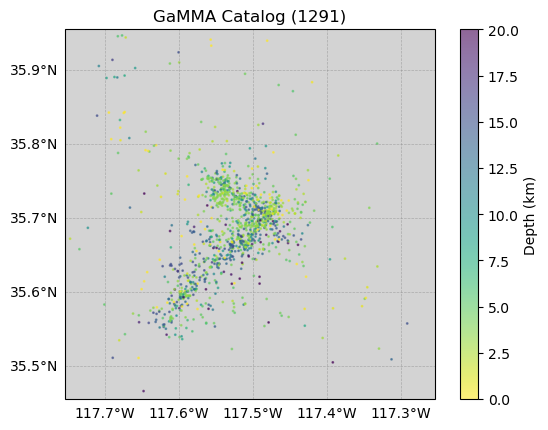

In [31]:
plot_catalog(gamma_catalog, "GaMMA", region=region, config=config)

In [18]:
def run_adloc(root_path: str = "local", region: str = "demo", config: Dict = {}):

    data_path = f"{root_path}/{region}/gamma"
    result_path = f"{root_path}/{region}/adloc"
    figure_path = f"{root_path}/{region}/adloc/figures"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)

    picks_file = f"{data_path}/gamma_picks.csv"
    events_file = f"{data_path}/gamma_events.csv"
    stations_file = f"{root_path}/{region}/obspy/stations.json"

    proj = Proj(f"+proj=sterea +lon_0={config['longitude0']} +lat_0={config['latitude0']}  +units=km")

    ## read picks and associated events
    picks = pd.read_csv(picks_file)
    picks["phase_time"] = pd.to_datetime(picks["phase_time"])
     # drop unnecessary columns
    picks.drop(["id", "timestamp", "type", "amp", "prob", "event_idx"], axis=1, inplace=True, errors="ignore")
    if os.path.exists(events_file):
        events = pd.read_csv(events_file)
        events["time"] = pd.to_datetime(events["time"])
        events[["x_km", "y_km"]] = events.apply(
            lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
        )
        events["z_km"] = events["depth_km"] if "depth_km" in events.columns else 10.0
    else:
        events = None

    ## read stations
    # stations = pd.read_csv(stations_file, sep="\t")
    stations = pd.read_json(stations_file, orient="index")
    stations["station_id"] = stations.apply(lambda x: f"{x['network']}.{x['station']}.{x['location']}.{x['channel'][:-1]}", axis=1)
    stations = stations.groupby("station_id").agg(lambda x: x.iloc[0] if len(set(x)) == 1 else sorted(list(x))).reset_index()
    stations["depth_km"] = -stations["elevation_m"] / 1000
    if "station_term_time_p" not in stations.columns:
        stations["station_term_time_p"] = 0.0
    if "station_term_time_s" not in stations.columns:
        stations["station_term_time_s"] = 0.0
    if "station_term_amplitude" not in stations.columns:
        stations["station_term_amplitude"] = 0.0
    stations[["x_km", "y_km"]] = stations.apply(
        lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
    )
    stations["z_km"] = stations["elevation_m"].apply(lambda x: -x / 1e3)

    ## setting ADLoc configs
    config["use_amplitude"] = True

    minlat, maxlat = config["latitude0"] - config["maxradius_degree"], config["latitude0"] + config["maxradius_degree"]
    minlon, maxlon = config["longitude0"] - config["maxradius_degree"], config["longitude0"] + config["maxradius_degree"]
    xmin, ymin = proj(minlon, minlat)
    xmax, ymax = proj(maxlon, maxlat)
    zmin, zmax = config["mindepth"], config["maxdepth"]
    config["xlim_km"] = (xmin, xmax)
    config["ylim_km"] = (ymin, ymax)
    config["zlim_km"] = (zmin, zmax)

    ## Eikonal for 1D velocity model
    zz = [0.0, 5.5, 5.5, 16.0, 16.0, 32.0, 32.0]
    vp = [5.5, 5.5, 6.3, 6.3, 6.7, 6.7, 7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    # Northern California (Gil7)
    # zz = [0.0, 1.0, 3.0, 4.0, 5.0, 17.0, 25.0, 62.0]
    # vp = [3.2, 3.2, 4.5, 4.8, 5.51, 6.21, 6.89, 7.83]
    # vs = [1.5, 1.5, 2.4, 2.78, 3.18, 3.40, 3.98, 4.52]
    h = 0.3
    vel = {"Z": zz, "P": vp, "S": vs}
    config["eikonal"] = {
        "vel": vel,
        "h": h,
        "xlim_km": config["xlim_km"],
        "ylim_km": config["ylim_km"],
        "zlim_km": config["zlim_km"],
    }
    config["eikonal"] = init_eikonal2d(config["eikonal"])

    # RASAC
    config["min_picks"] = 6
    config["min_picks_ratio"] = 0.5
    config["max_residual_time"] = 1.0
    config["max_residual_amplitude"] = 1.0
    config["min_score"] = 0.5
    config["min_s_picks"] = 1.5
    config["min_p_picks"] = 1.5

    config["bfgs_bounds"] = (
        (config["xlim_km"][0] - 1, config["xlim_km"][1] + 1),  # x
        (config["ylim_km"][0] - 1, config["ylim_km"][1] + 1),  # y
        (0, config["zlim_km"][1] + 1),
        (None, None),  # t
    )

    # %%
    mapping_phase_type_int = {"P": 0, "S": 1}
    picks["phase_type"] = picks["phase_type"].map(mapping_phase_type_int)
    if "phase_amplitude" in picks.columns:
        picks["phase_amplitude"] = picks["phase_amplitude"].apply(lambda x: np.log10(x) + 2.0)  # convert to log10(cm/s)

    # %%
    stations["idx_sta"] = np.arange(len(stations))
    if events is None:
        picks = picks.merge(stations[["station_id", "x_km", "y_km", "z_km"]], on="station_id")
        events = picks.groupby("event_index").agg({"x_km": "mean", "y_km": "mean", "z_km": "mean", "phase_time": "min"})
        events["z_km"] = 10.0  # km default depth
        events.rename({"phase_time": "time"}, axis=1, inplace=True)
        events["event_index"] = events.index
        events.reset_index(drop=True, inplace=True)
        events["idx_eve"] = np.arange(len(events))
        picks.drop(["x_km", "y_km", "z_km"], axis=1, inplace=True)
    else:
        events["idx_eve"] = np.arange(len(events))

    picks = picks.merge(events[["event_index", "idx_eve"]], on="event_index")
    picks = picks.merge(stations[["station_id", "idx_sta"]], on="station_id")


    # for key, value in config.items():
    #     print(f"{key}: {value}")

    print(f"Number of picks: {len(picks)}")
    print(f"Number of events: {len(events)}")

    # %%
    estimator = ADLoc(config, stations=stations[["x_km", "y_km", "z_km"]].values, eikonal=config["eikonal"])

    # %%
    MAX_SST_ITER = 8
    events_init = events.copy()

    for iter in range(MAX_SST_ITER):
        picks, events = invert_location(picks, stations, config, estimator, events_init=events_init, iter=iter)

        station_term_amp = (
            picks[picks["mask"] == 1.0].groupby("idx_sta").agg({"residual_amplitude": "median"}).reset_index()
        )
        station_term_amp.set_index("idx_sta", inplace=True)
        stations["station_term_amplitude"] += stations["idx_sta"].map(station_term_amp["residual_amplitude"]).fillna(0)

        station_term_time = (
            picks[picks["mask"] == 1.0].groupby(["idx_sta", "phase_type"]).agg({"residual_time": "mean"}).reset_index()
        )
        station_term_time.set_index("idx_sta", inplace=True)
        stations["station_term_time_p"] += (
            stations["idx_sta"].map(station_term_time[station_term_time["phase_type"] == 0]["residual_time"]).fillna(0)
        )
        stations["station_term_time_s"] += (
            stations["idx_sta"].map(station_term_time[station_term_time["phase_type"] == 1]["residual_time"]).fillna(0)
        )

        if "event_index" not in events.columns:
            events["event_index"] = events.merge(picks[["idx_eve", "event_index"]], on="idx_eve")["event_index"]
        events[["longitude", "latitude"]] = events.apply(
            lambda x: pd.Series(proj(x["x_km"], x["y_km"], inverse=True)), axis=1
        )
        events["depth_km"] = events["z_km"]

        picks["adloc_mask"] = picks["mask"]
        picks["adloc_residual_time"] = picks["residual_time"]
        picks["adloc_residual_amplitude"] = picks["residual_amplitude"]

        picks.to_csv(os.path.join(result_path, f"adloc_picks_sst_{iter}.csv"), index=False)
        events.to_csv(os.path.join(result_path, f"adloc_events_sst_{iter}.csv"), index=False)
        stations.to_csv(os.path.join(result_path, f"adloc_stations_sst_{iter}.csv"), index=False)

    # %%
    if "event_index" not in events.columns:
        events["event_index"] = events.merge(picks[["idx_eve", "event_index"]], on="idx_eve")["event_index"]
    events[["longitude", "latitude"]] = events.apply(
        lambda x: pd.Series(proj(x["x_km"], x["y_km"], inverse=True)), axis=1
    )
    events["depth_km"] = events["z_km"]
    events.drop(["idx_eve", "x_km", "y_km", "z_km"], axis=1, inplace=True, errors="ignore")
    events.sort_values(["time"], inplace=True)

    picks["phase_type"] = picks["phase_type"].map({0: "P", 1: "S"})
    picks.drop(
        ["idx_eve", "idx_sta", "mask", "residual_time", "residual_amplitude"], axis=1, inplace=True, errors="ignore"
    )
    picks.sort_values(["phase_time"], inplace=True)

    stations.drop(["idx_sta", "x_km", "y_km", "z_km"], axis=1, inplace=True, errors="ignore")

    picks.to_csv(os.path.join(result_path, "adloc_picks.csv"), index=False)
    events.to_csv(os.path.join(result_path, "adloc_events.csv"), index=False)
    stations.to_csv(os.path.join(result_path, "adloc_stations.csv"), index=False)

    return events

In [19]:
adloc_catalog = run_adloc(region=region, config=config)

Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 2.695
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.028
Number of picks: 21647
Number of events: 1292


Iter 0: 100%|██████████| 1292/1292 [00:12<00:00, 100.66it/s]

ADLoc locates 1027 events outof 1292 events
using 19201 picks outof 21647 picks



Iter 1: 100%|██████████| 1292/1292 [00:12<00:00, 105.45it/s]

ADLoc locates 1012 events outof 1292 events
using 19040 picks outof 21647 picks



Iter 2: 100%|██████████| 1292/1292 [00:12<00:00, 105.15it/s]

ADLoc locates 1012 events outof 1292 events
using 19014 picks outof 21647 picks



Iter 3: 100%|██████████| 1292/1292 [00:11<00:00, 108.55it/s]

ADLoc locates 1012 events outof 1292 events
using 19018 picks outof 21647 picks



Iter 4: 100%|██████████| 1292/1292 [00:12<00:00, 105.66it/s]

ADLoc locates 1010 events outof 1292 events
using 18981 picks outof 21647 picks


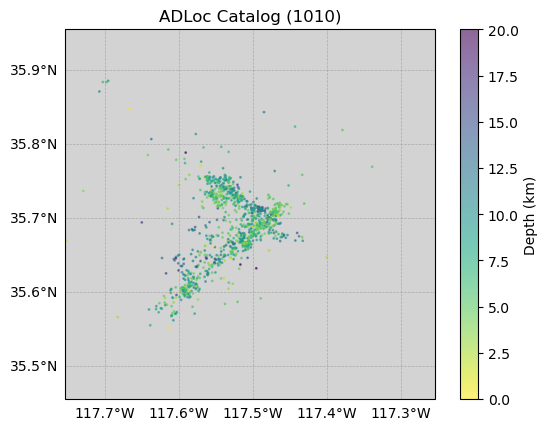

In [32]:
plot_catalog(adloc_catalog, "ADLoc", region=region, config=config)

In [40]:
def run_hypodd(root_path: str = "local", region: str = "demo"):

    data_path = f"{region}/adloc"
    result_path = f"{region}/hypodd"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")

    ## Station Format
    stations = pd.read_csv(f"{root_path}/{data_path}/adloc_stations.csv")
    stations.set_index("station_id", inplace=True)

    shift_topo = stations["elevation_m"].max() / 1e3
    converted_hypoinverse = []
    converted_hypodd = {}

    for sta, row in stations.iterrows():
        network_code, station_code, comp_code, channel_code = sta.split(".")
        station_weight = " "
        lat_degree = int(row["latitude"])
        lat_minute = (row["latitude"] - lat_degree) * 60
        north = "N" if lat_degree >= 0 else "S"
        lng_degree = int(row["longitude"])
        lng_minute = (row["longitude"] - lng_degree) * 60
        west = "W" if lng_degree <= 0 else "E"
        elevation = row["elevation_m"]
        line_hypoinverse = f"{station_code:<5} {network_code:<2} {comp_code[:-1]:<1}{channel_code:<3} {station_weight}{abs(lat_degree):2.0f} {abs(lat_minute):7.4f}{north}{abs(lng_degree):3.0f} {abs(lng_minute):7.4f}{west}{elevation:4.0f}\n"
        converted_hypoinverse.append(line_hypoinverse)

        # tmp_code = f"{station_code}{channel_code}"
        tmp_code = f"{station_code}"
        converted_hypodd[tmp_code] = f"{tmp_code:<8s} {row['latitude']:.3f} {row['longitude']:.3f}\n"


    with open(f"{root_path}/{result_path}/stations.dat", "w") as f:
        for k, v in converted_hypodd.items():
            f.write(v)


    ## Picks Format
    picks_csv = f"{data_path}/adloc_picks.csv"
    events_csv = f"{data_path}/adloc_events.csv"

    picks = pd.read_csv(f"{root_path}/{picks_csv}")
    events = pd.read_csv(f"{root_path}/{events_csv}")
    picks["phase_time"] = pd.to_datetime(picks["phase_time"], format="mixed")
    events["time"] = pd.to_datetime(events["time"])
    # events["magnitude"] = 1.0
    events["sigma_time"] = 1.0

    # events.sort_values("time", inplace=True)
    picks = picks.loc[picks["event_index"].isin(events["event_index"])]

    lines = []
    picks_by_event = picks.groupby("event_index").groups
    for i, event in tqdm(events.iterrows(), desc="Convert catalog", total=len(events)):
        # event_time = datetime.strptime(event["time"], "%Y-%m-%dT%H:%M:%S.%f")
        event_time = event["time"]
        lat = event["latitude"]
        lng = event["longitude"]
        # dep = event["depth(m)"] / 1e3 + shift_topo
        dep = event["depth_km"] + shift_topo
        mag = event["magnitude"]
        EH = 0
        EZ = 0
        RMS = event["sigma_time"]

        year, month, day, hour, min, sec = (
            event_time.year,
            event_time.month,
            event_time.day,
            event_time.hour,
            event_time.minute,
            float(event_time.strftime("%S.%f")),
        )
        event_line = f"# {year:4d} {month:2d} {day:2d} {hour:2d} {min:2d} {sec:5.2f}  {lat:7.4f} {lng:9.4f}   {dep:5.2f} {mag:5.2f} {EH:5.2f} {EZ:5.2f} {RMS:5.2f} {event['event_index']:9d}\n"

        lines.append(event_line)

        picks_idx = picks_by_event[event["event_index"]]
        for j in picks_idx:
            # pick = picks.iloc[j]
            pick = picks.loc[j]
            network_code, station_code, comp_code, channel_code = pick["station_id"].split(".")
            phase_type = pick["phase_type"].upper()
            phase_score = pick["phase_score"]
            # pick_time = (datetime.strptime(pick["phase_time"], "%Y-%m-%dT%H:%M:%S.%f") - event_time).total_seconds()
            pick_time = (pick["phase_time"] - event_time).total_seconds()
            tmp_code = f"{station_code}"
            pick_line = f"{tmp_code:<7s}   {pick_time:6.3f}   {phase_score:5.4f}   {phase_type}\n"
            lines.append(pick_line)

    with open(f"{root_path}/{result_path}/phase.txt", "w") as fp:
        fp.writelines(lines)

    ## Run Hypodd
    print(f"Running Hypodd:")
    os.system(f"bash run_hypodd_ct.sh {root_path} {region}")

    ## Read  catalog
    columns = ["ID", "LAT", "LON", "DEPTH", "X", "Y", "Z", "EX", "EY", "EZ", "YR", "MO", "DY", "HR", "MI", "SC", "MAG", "NCCP", "NCCS", "NCTP", "NCTS", "RCC", "RCT", "CID"]
    catalog_ct_hypodd = pd.read_csv(f"{root_path}/{region}/hypodd/hypodd_ct.reloc", sep="\s+", header=None, names=columns, dtype=float)
    catalog_ct_hypodd["time"] = catalog_ct_hypodd.apply(
        lambda x: f'{x["YR"]:04.0f}-{x["MO"]:02.0f}-{x["DY"]:02.0f}T{x["HR"]:02.0f}:{x["MI"]:02.0f}:{np.min([float(x["SC"]), 59.999]):05.3f}',
        axis=1,
    )
    catalog_ct_hypodd["time"] = catalog_ct_hypodd["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
    catalog_ct_hypodd = catalog_ct_hypodd[catalog_ct_hypodd["DEPTH"] != "*********"]
    catalog_ct_hypodd["DEPTH"] = catalog_ct_hypodd["DEPTH"].astype(float)
    catalog_ct_hypodd.rename({"ID": "event_index", "LAT": "latitude", "LON": "longitude", "DEPTH": "depth_km", "MAG": "magnitude"}, axis=1, inplace=True)
    catalog_ct_hypodd.to_csv(f"{root_path}/{region}/hypodd/hypodd_ct.csv", index=False)

    return catalog_ct_hypodd

In [41]:
hypodd_catalog = run_hypodd(region=region)

Convert catalog: 100%|██████████| 1010/1010 [00:01<00:00, 608.92it/s]
+ WORKING_DIR=/nfs/zhuwq/Earthquake-Catalog-Workshop/notebooks
+ '[' 2 -eq 2 ']'
+ root_path=local
+ region=demo
+ data_path=local/demo/hypodd
+ '[' '!' -d local/demo/hypodd ']'
+ cd local/demo/hypodd
+ '[' '!' -d HypoDD ']'
+ cat
+ cat
+ ./HypoDD/src/ph2dt/ph2dt ph2dt.inp


Running Hypodd:
starting ph2dt (v2.1b - 08/2012)...     Sun Apr  6 17:04:35 2025 

reading data ...
 > stations =           15
 > events total =         1010
 > events selected =          983
 > phases =        19290
forming dtimes...
 > stations selected =           14
 > P-phase pairs total =       246893
 > S-phase pairs total =       267115
 > outliers =        18849  (           3 %)
 > phases at stations not in station list =            0
 > phases at distances larger than MAXDIST =            0
 > P-phase pairs selected =       219197  (          88 %)
 > S-phase pairs selected =       242204  (          90 %)
 > weakly linked events =           34  (           3 %)
 > linked event pairs =        30440
 > average links per pair =           15
 > average offset (km) betw. linked events =    2.59696007    
 > average offset (km) betw. strongly linked events =    2.59696007    
 > maximum offset (km) betw. strongly linked events =    9.98896217    

Done.  Sun Apr  6 17:04:36 2025 

+ ./HypoDD/src/hypoDD/hypoDD ct.inp


# catalog P dtimes =  219197
# catalog S dtimes =  242204
# dtimes total =   461401
# events after dtime match =        975
# stations =     14

no clustering performed.

RELOCATION OF CLUSTER: 1     Sun Apr  6 17:04:38 2025 
----------------------
Initial trial sources =   975
1D ray tracing.

  IT   EV  CT    RMSCT   RMSST   DX   DY   DZ   DT   OS  AQ  CND
        %   %   ms     %    ms    m    m    m   ms    m 
 1    100  99  149 -11.6     0  229  200 1448   59    0  13  227
 2  1  99  98  146  -1.7   332  226  196 1313   56  426   0  226
 3     99  95  123 -16.2   332  139  120  514   31  426   5  236
 4  2  98  94  120  -2.2   298  140  120  450   31  306   0  236
 5     98  93  108  -9.5   298   97   63  511   19  306   7  231
 6  3  97  92  107  -1.5   278   97   63  400   19  114   0  228
 7     97  91  101  -5.2   278   84   40  498   11  114   7  227
 8  4  97  90  100  -0.9   267   82   40  383   11  166   0  224
 9  5  94  73   88 -12.4   216   68   54  207   14  403   0  2

+ cd /nfs/zhuwq/Earthquake-Catalog-Workshop/notebooks


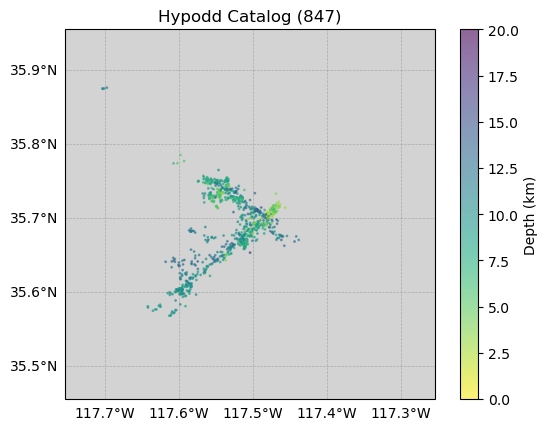

In [42]:
plot_catalog(hypodd_catalog, "Hypodd", region=region, config=config)